In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
# Depths will be limited to COW depths
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row


eddy = the_frontier_eddies[2]


sub_data = {}
for t in range(30):
    
    method = 'VG'
    sub_data['T'+str(t)] = {}
    
    df = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_df.loc[eddy]['T'+str(t)]]
    df = df.drop('TD', axis=1)
    
    # Interpolate to Density intervals
    rho = frontier_sample_data[eddy]['T'+str(t)]['rho']
    X, Y = np.meshgrid(frontier_sample_data[eddy]['T'+str(t)]['x'],
                       frontier_sample_data[eddy]['T'+str(t)]['y'])
    points = np.column_stack((X.ravel(), Y.ravel()))
    rhoc = []
    for k, (xc, yc) in enumerate(zip(df['x'], df['y'])):
        values = rho[:, :, k].ravel()
        target_point = np.array([[xc, yc]])
        rhoc.append(griddata(points, values, target_point, method='linear')[0])
    RHO_INT = 0.05
    new_rho = np.arange(np.floor(np.nanmin(rhoc) / RHO_INT) * RHO_INT,
                    np.ceil(np.nanmax(rhoc) / RHO_INT) * RHO_INT + RHO_INT,
                    RHO_INT)
    new_rho = [round(value, 2) for value in new_rho]
    rho_data = pd.DataFrame({
        'x': np.interp(new_rho, rhoc, df['x']),
        'y': np.interp(new_rho, rhoc, df['y']),
        'Depth': np.interp(new_rho, rhoc, df['Depth']),
        'rho': new_rho
    })
    x0 = rho_data.iloc[0]['x']
    y0 = rho_data.iloc[0]['y']
    rho_data['x'] = rho_data['x'] - x0
    rho_data['y'] = rho_data['y'] - y0
    rho_data['TD'] = np.hypot(rho_data['x'], rho_data['y'])
    
    # Interpolate to Depth intervals
    DEPTH_INT = 10
    new_depth = np.arange(0, -np.floor(df['Depth'].min()/DEPTH_INT) * DEPTH_INT + DEPTH_INT, DEPTH_INT)
    depth_data = pd.DataFrame({
        'x': np.interp(new_depth, -df['Depth'], df['x']),
        'y': np.interp(new_depth, -df['Depth'], df['y']),
        'Depth': -new_depth,
        'rho': np.interp(new_depth, -df['Depth'], rhoc),
    })
    x0 = depth_data.iloc[0]['x']
    y0 = depth_data.iloc[0]['y']
    depth_data['x'] = depth_data['x'] - x0
    depth_data['y'] = depth_data['y'] - y0
    depth_data['TD'] = np.hypot(depth_data['x'], depth_data['y'])

    sub_data['T'+str(t)]['rho_data'] = rho_data
    sub_data['T'+str(t)]['depth_data'] = depth_data
    print(t)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


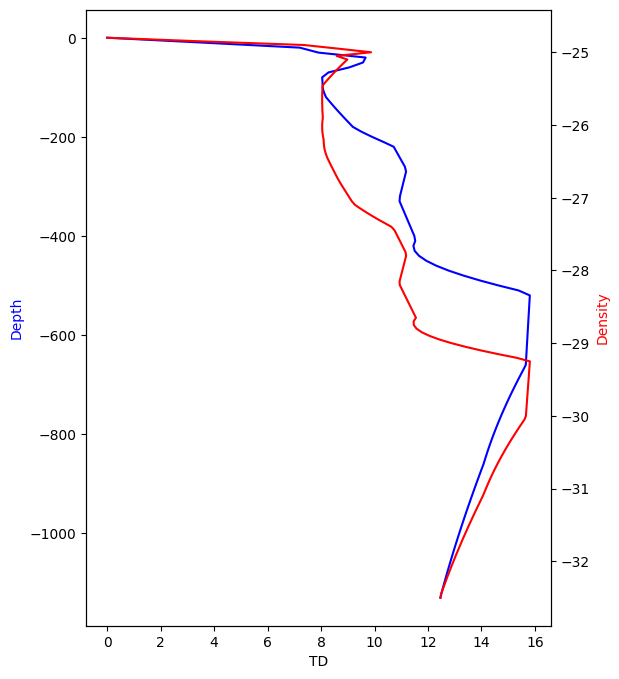

In [51]:
t = 26

rho_data =     sub_data['T'+str(t)]['rho_data'] 
depth_data =    sub_data['T'+str(t)]['depth_data'] 

fig, ax1 = plt.subplots(figsize=(6, 8))
# Plot depth data
ax1.plot(depth_data['TD']/1000, depth_data['Depth'], 'b-')
ax1.set_xlabel('TD')
ax1.set_ylabel('Depth', color='b')

# Create a second y-axis for density data
ax2 = ax1.twinx()
ax2.plot(rho_data['TD']/1000, -rho_data['rho'], 'r-')
ax2.set_ylabel('Density', color='r')

plt.show()

## $\rho$

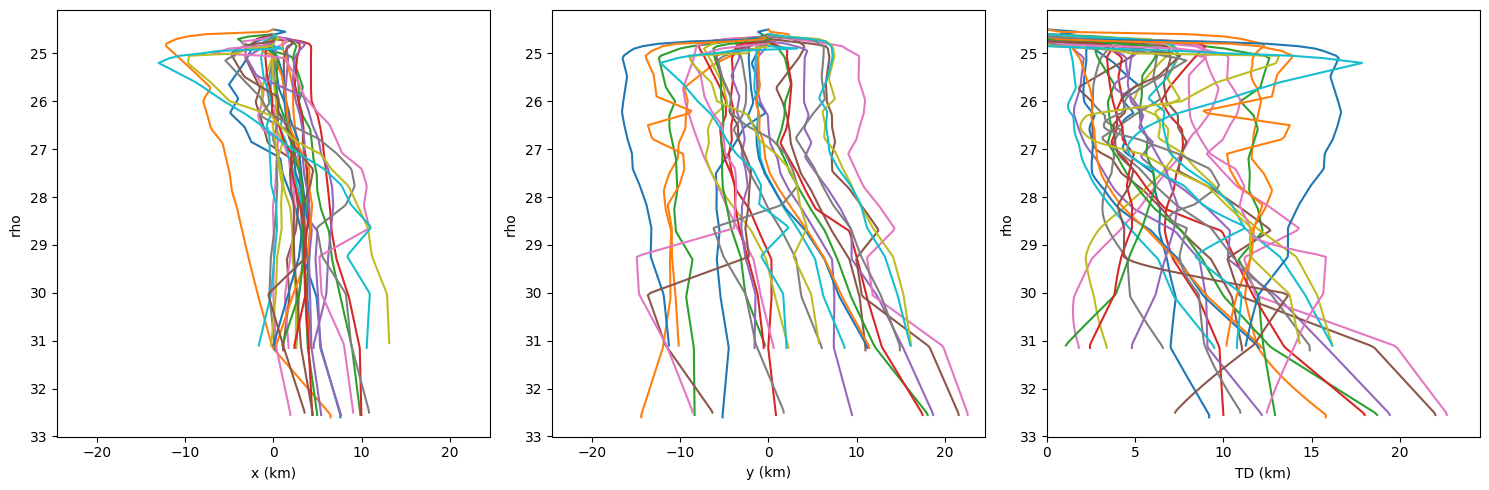

In [54]:
# PROCESS DATA INTO DATAFRAME

rho_dfs = []
for t in range(30):
    for col in ['x', 'y', 'TD']:
        rho_data = sub_data[f'T{t}']['rho_data'][['rho', col]]
        rho_data.columns = ['rho', f'{col}{t}']
        rho_dfs.append(rho_data.set_index('rho'))

rho_df = pd.concat(rho_dfs, axis=1).sort_index()

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
for col in rho_df.columns:
    t = extract_number(col)
  
    if 'x' in col:
        xa =rho_df[col]/1000
        xb = rho_df[col].index
        axs[0].plot(rho_df[col]/1000, rho_df[col].index)
        axs[0].set_xlabel('x (km)')
        axs[0].set_ylabel('rho ')
    if 'y' in col:
        axs[1].plot(rho_df[col]/1000, rho_df[col].index)
        axs[1].set_xlabel('y (km)')
        axs[1].set_ylabel('rho ')
    if 'TD' in col:
        axs[2].plot(rho_df[col]/1000, rho_df[col].index)
        axs[2].set_xlabel('TD (km)')
        axs[2].set_ylabel('rho')

xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)
    ax.invert_yaxis()

axs[0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[2].set_xlim(0, max(abs(xmin),abs(xmax)))

plt.tight_layout()
plt.show()

In [6]:
# COMPUTE RMSE FOR DIFFERENT SHIFTS

RHO_THRESH = 0

x0 = rho_df['x14'].loc[rho_df.index >= RHO_THRESH]/1000
y0 = rho_df['y14'].loc[rho_df.index >= RHO_THRESH]/1000
TD0 = rho_df['TD14'].loc[rho_df.index >= RHO_THRESH]/1000 # CHOOSE FROM SEPCIFIC RHO

x_shift_df = pd.DataFrame(columns=['Day', 'i', 'rmse'])
y_shift_df = pd.DataFrame(columns=['Day', 'i', 'rmse'])
TD_shift_df = pd.DataFrame(columns=['Day', 'i', 'rmse'])

tic = time.time()
for col in rho_df.columns:
    t = extract_number(col)

    for i_shift in range(-20, 20):

        if 'x' in col:
            x1 = rho_df[col].loc[rho_df.index >= RHO_THRESH]/1000 + i_shift
            rmse_x = np.sqrt(np.nanmean((x1 - x0) ** 2))

            x_shift_df.loc[len(x_shift_df)] = {
                'Day': t,
                'i': i_shift,
                'rmse': rmse_x,
            }
        elif 'y' in col:
            y1 = rho_df[col].loc[rho_df.index >= RHO_THRESH]/1000 + i_shift
            rmse_y = np.sqrt(np.nanmean((y1 - y0) ** 2))

            y_shift_df.loc[len(y_shift_df)] = {
                'Day': t,
                'i': i_shift,
                'rmse': rmse_y,
            }
        elif 'TD' in col:
            TD1 = rho_df[col].loc[rho_df.index >= RHO_THRESH]/1000 + i_shift
            rmse_TD = np.sqrt(np.nanmean((TD1 - TD0) ** 2))
            TD_shift_df.loc[len(TD_shift_df)] = {
                    'Day': t,
                    'i': i_shift,
                    'rmse': rmse_TD,
                }
                    
    if 'TD' in col:
        print(t)
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Elapsed time: 3.4253 seconds


In [7]:
rho_df

,x0,y0,TD0,x1,y1,TD1,x2,y2,TD2,x3,...,TD26,x27,y27,TD27,x28,y28,TD28,x29,y29,TD29
rho,,,,,,,,,,,,,,,,,,,,,
24.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.55,1345.457789,-1176.229254,1787.112732,-708.568787,228.432582,744.480470,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.60,262.689697,-733.831970,779.432638,-7658.600149,2248.329164,7981.800565,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.65,-336.835870,-498.065381,601.271592,-9809.392615,2401.481005,10099.073943,-2835.683707,-934.166620,2985.593636,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.70,-1105.004389,-525.688557,1223.676084,-10975.461670,1304.997319,11052.772362,-4015.073103,-2527.407565,4744.323031,1526.910322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32.40,7351.001446,-5122.519586,8959.767250,5795.909013,-14161.511998,15301.666032,9756.652616,-8380.405731,12861.705583,9946.411126,...,12537.138913,10724.292996,1572.631757,10838.986618,NaN,NaN,NaN,NaN,NaN,NaN
32.45,7429.665651,-5147.597729,9038.677672,6030.699448,-14249.118438,15472.773252,9790.745496,-8377.419753,12885.645466,9953.052696,...,12489.140524,10796.878967,1686.039479,10927.731903,NaN,NaN,NaN,NaN,NaN,NaN
32.50,7508.329855,-5172.675872,9117.652817,6265.489884,-14336.724878,15646.023256,9824.838375,-8374.433775,12909.631681,9959.694266,...,12464.424702,10826.572299,1732.432097,10964.305209,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# FIND OPTIMAL SHIFTS

x_best_shift_df = pd.DataFrame()
for t in x_shift_df['Day'].unique():
    day_df = x_shift_df.loc[x_shift_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        x_best_shift_df = pd.concat([x_best_shift_df, day_df_nonan.loc[[min_rmse_idx]]])
x_best_shift_df.set_index('Day', inplace=True)
x_best_shift_df.columns = ['ix', 'rmsex']

y_best_shift_df = pd.DataFrame()
for t in y_shift_df['Day'].unique():
    day_df = y_shift_df.loc[y_shift_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        y_best_shift_df = pd.concat([y_best_shift_df, day_df_nonan.loc[[min_rmse_idx]]])
y_best_shift_df.set_index('Day', inplace=True)
y_best_shift_df.columns = ['iy', 'rmsey']

TD_best_shift_df = pd.DataFrame()
for t in TD_shift_df['Day'].unique():
    day_df = TD_shift_df.loc[TD_shift_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        TD_best_shift_df = pd.concat([TD_best_shift_df, day_df_nonan.loc[[min_rmse_idx]]])
TD_best_shift_df.set_index('Day', inplace=True)
TD_best_shift_df.columns = ['iTD', 'rmseTD']

best_shift_df = pd.concat([x_best_shift_df, y_best_shift_df, TD_best_shift_df], axis=1)
best_shift_df

,ix,rmsex,iy,rmsey,iTD,rmseTD
Day,,,,,,
0,2,3.141942,14,6.161526,4,3.446485
1,7,3.544594,19,7.177991,-2,4.427132
2,-2,2.131788,19,4.291972,-2,4.461828
3,-3,1.366535,12,2.785773,2,3.989248
4,0,1.124701,5,1.910052,4,1.760426
5,3,1.368290,2,1.151634,2,1.210794
6,3,1.316134,13,1.292554,3,6.605706
7,2,1.055981,8,1.030184,5,2.898154
8,2,0.794306,11,1.398599,4,5.188205


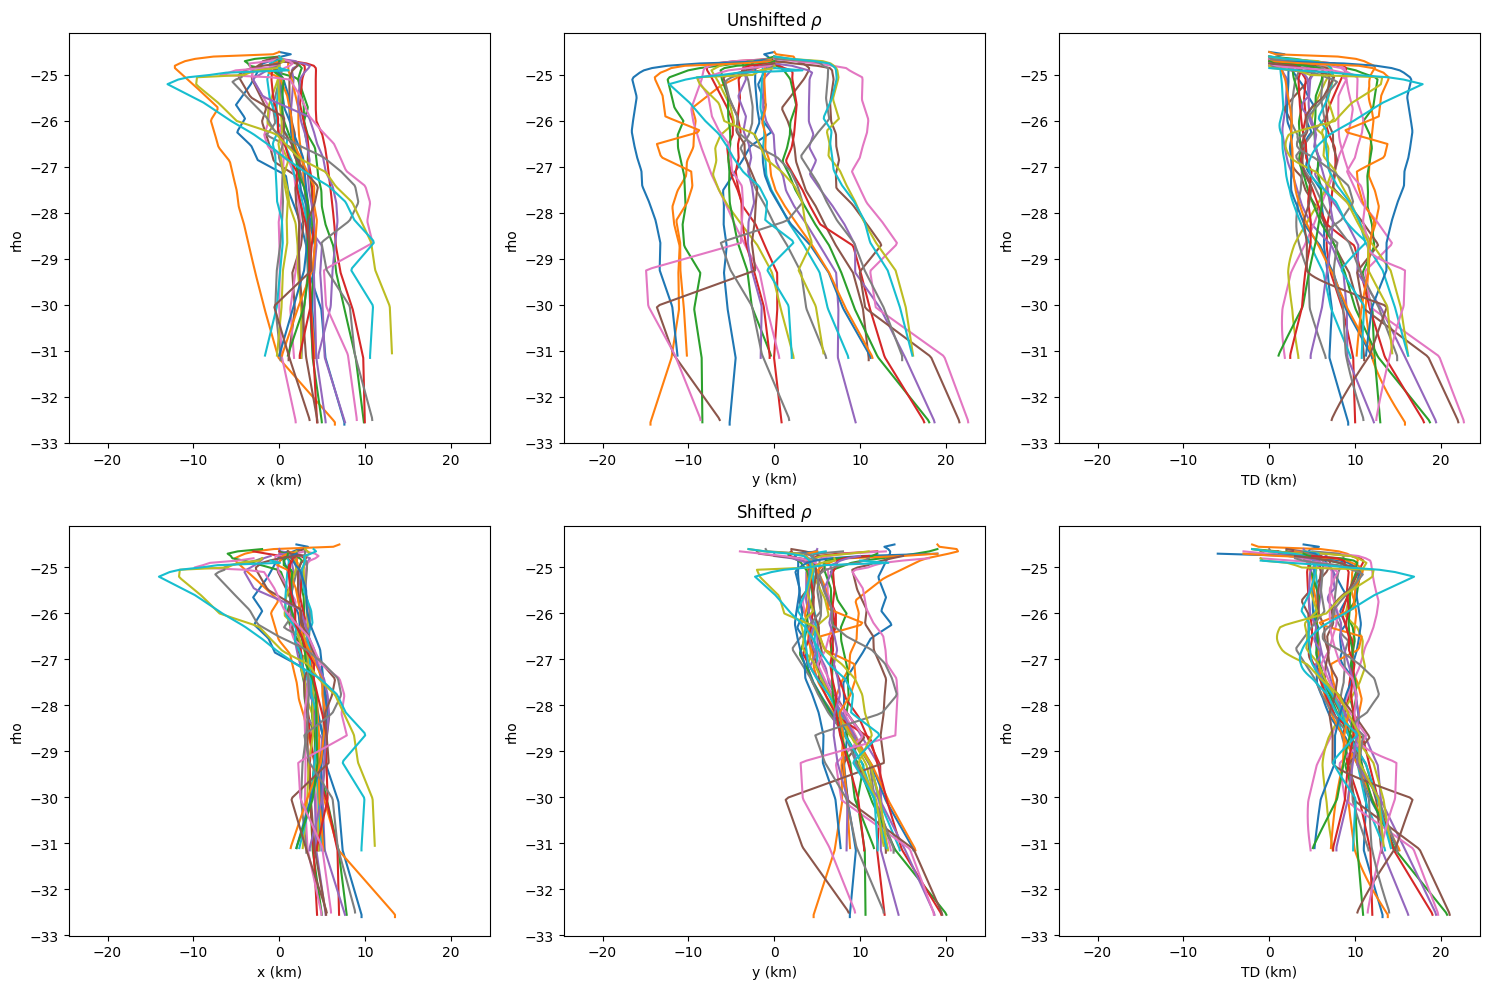

In [55]:
# SHFIT RESULTS

fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
for col in rho_df.columns:
    t = extract_number(col)
    if 'x' in col:
        axs[0,0].plot(rho_df[col]/1000, -rho_df.index)
        axs[0,0].set_xlabel('x (km)')
        axs[0,0].set_ylabel('rho')
        ix = best_shift_df.loc[t]['ix']
        x = rho_df[col]/1000 + ix
        axs[1,0].plot(x, -rho_df.index)
        axs[1,0].set_xlabel('x (km)')
        axs[1,0].set_ylabel('rho')
    if 'y' in col:
        axs[0,1].plot(rho_df[col]/1000, -rho_df.index)
        axs[0,1].set_xlabel('y (km)')
        axs[0,1].set_ylabel('rho')
        axs[0,1].set_title(r'Unshifted $\rho$')
        iy = best_shift_df.loc[t]['iy']
        y = rho_df[col]/1000 + iy
        axs[1,1].plot(y, -rho_df.index)
        axs[1,1].set_xlabel('y (km)')
        axs[1,1].set_ylabel('rho')
        axs[1,1].set_title(r'Shifted $\rho$')
    if 'TD' in col:
        axs[0,2].plot(rho_df[col]/1000, -rho_df.index)
        axs[0,2].set_xlabel('TD (km)')
        axs[0,2].set_ylabel('rho')
        iTD = best_shift_df.loc[t]['iTD']
        TD = rho_df[col]/1000 + iTD
        axs[1,2].plot(TD, -rho_df.index)
        axs[1,2].set_xlabel('TD (km)')
        axs[1,2].set_ylabel('rho')

xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)

for ax in axs.flat:
    ax.set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
    
plt.tight_layout()
plt.show()

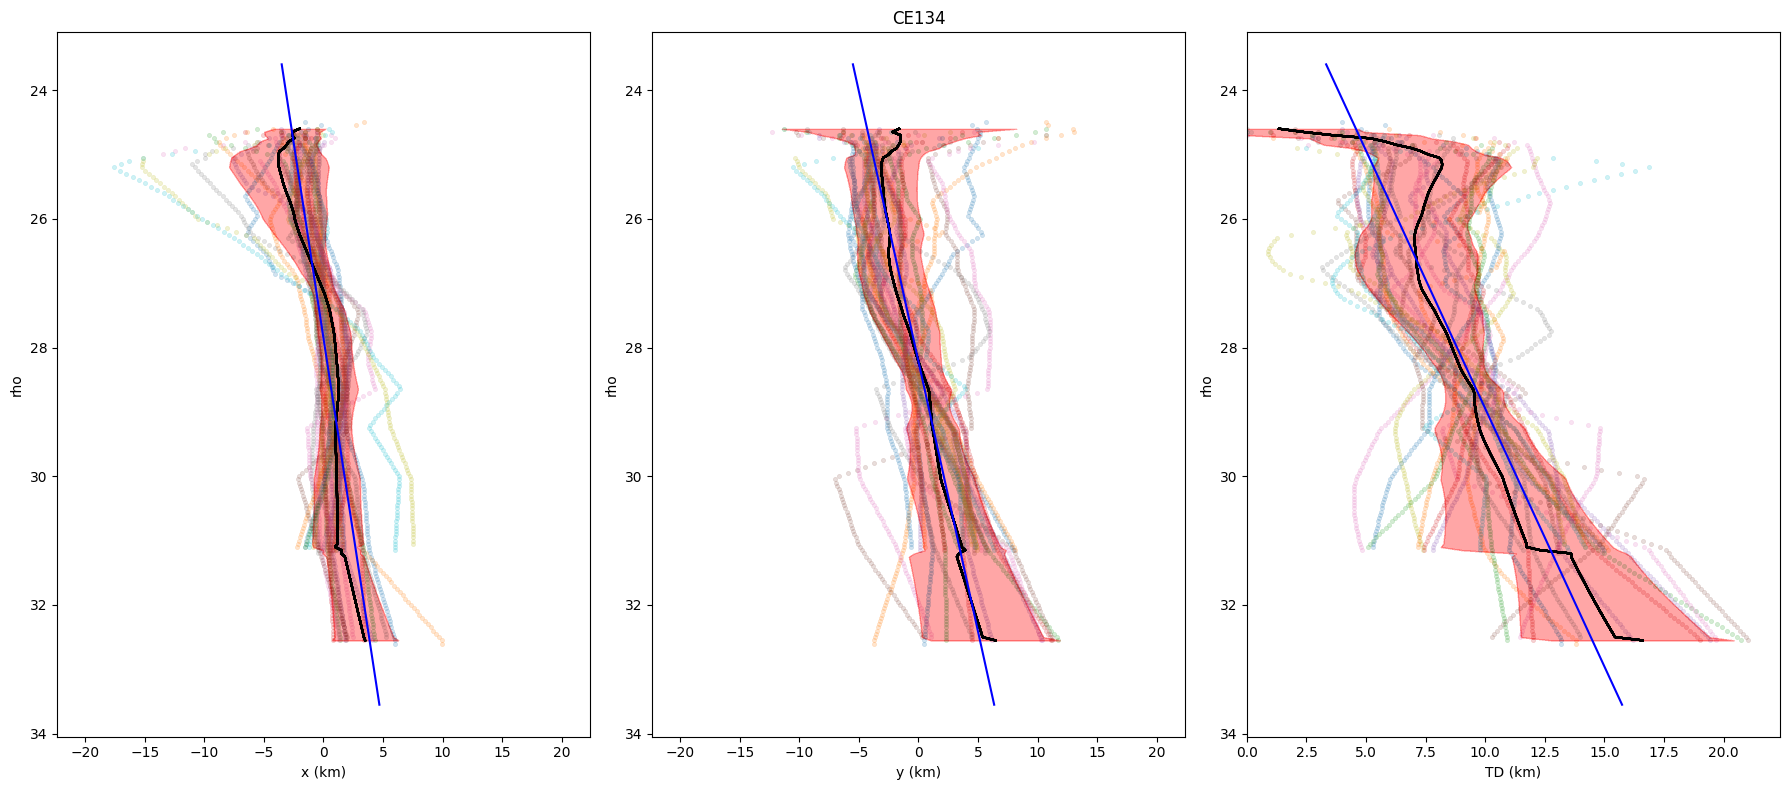

In [47]:
# LINEAR REGRESSION WITH SHIFT

shifted_rho_df = rho_df.copy()
for col in shifted_rho_df.columns:
    t = extract_number(col)
    if 'x' in col:
        ix = best_shift_df.loc[t]['ix']
        shifted_rho_df[col] = shifted_rho_df[col]/1000 + ix 
    if 'y' in col:
        iy = best_shift_df.loc[t]['iy']
        shifted_rho_df[col] = shifted_rho_df[col]/1000 + iy
    if 'TD' in col:
        iTD = best_shift_df.loc[t]['iTD']
        shifted_rho_df[col] = shifted_rho_df[col]/1000 + iTD

x_mean = shifted_rho_df.mean().filter(like='x').mean()
shifted_rho_df.loc[:, shifted_rho_df.columns.str.contains('x')] -= x_mean

y_mean = shifted_rho_df.mean().filter(like='y').mean()
shifted_rho_df.loc[:, shifted_rho_df.columns.str.contains('y')] -= y_mean

THRESHOLD = 5

x_df = shifted_rho_df.loc[:, shifted_rho_df.columns.str.contains('x')]
x_df = x_df[x_df.notna().sum(axis=1) >= THRESHOLD]
x_mean_d = x_df.mean(axis=1)
x_std_d = x_df.std(axis=1)

y_df = shifted_rho_df.loc[:, shifted_rho_df.columns.str.contains('y')]
y_df = y_df[y_df.notna().sum(axis=1) >= THRESHOLD]
y_mean_d = y_df.mean(axis=1)
y_std_d = y_df.std(axis=1)

TD_df = shifted_rho_df.loc[:, shifted_rho_df.columns.str.contains('TD')]
TD_df = TD_df[TD_df.notna().sum(axis=1) >= THRESHOLD]
TD_mean_d = TD_df.mean(axis=1)
TD_std_d = TD_df.std(axis=1)
# for col in shifted_rho_df.columns:
#     if 'TD' in col:
#         shifted_rho_df[col] -= TD_mean_d.iloc[0]
        
fig, axs = plt.subplots(1, 3, figsize=(18, 8)) 
for col in rho_df.columns:
    t = extract_number(col)
    if 'x' in col:
        x = shifted_rho_df[col]
        axs[0].scatter(x, rho_df.index, linewidth=.5, alpha=.2, zorder=-1, marker='.')
        axs[0].plot(x_mean_d, x_mean_d.index, color='k')
        axs[0].fill_betweenx(x_std_d.index, x_mean_d - x_std_d, x_mean_d + x_std_d, color='red', alpha=.01)
        axs[0].set_xlabel('x (km)')
        axs[0].set_ylabel('rho')

    if 'y' in col:
        y = shifted_rho_df[col]
        axs[1].scatter(y, rho_df.index, linewidth=.5, alpha=.2, zorder=-1, marker='.')
        axs[1].plot(y_mean_d, y_mean_d.index, color='k')
        axs[1].fill_betweenx(y_std_d.index, y_mean_d - y_std_d, y_mean_d + y_std_d, color='red', alpha=.01)
        axs[1].set_xlabel('y (km)')
        axs[1].set_ylabel('rho')
        axs[1].set_title('AE'+str(extract_number(eddy)) if eddies[eddy].iloc[0].Vort > 0 else 'CE'+str(extract_number(eddy)))

    if 'TD' in col:
        TD = shifted_rho_df[col]
        axs[2].scatter(TD, rho_df.index, linewidth=.5, alpha=.2, zorder=-1, marker='.')
        axs[2].plot(TD_mean_d, TD_mean_d.index, color='k')
        axs[2].fill_betweenx(TD_std_d.index, TD_mean_d - TD_std_d, TD_mean_d + TD_std_d, color='r', alpha=.01)
        axs[2].set_xlabel('TD (km)')
        axs[2].set_ylabel('rho')

# Linear Regression
means = [x_mean_d, y_mean_d, TD_mean_d]
stds = [x_std_d, y_std_d, TD_std_d]

for l, (mean, std) in enumerate(zip(means, stds)):

    x = mean
    z = mean.index
    w = 1 / std
    
    m, b = np.polyfit(x, z, 1, w=w)
    z_min, z_max = z.min() - 1, z.max() + 1
    x_min = (z_min - b) / m
    x_max = (z_max - b) / m
    x_fit = np.array([x_min, x_max])
    z_fit = m * x_fit + b
    axs[l].plot(x_fit, z_fit, color='b')
    
xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)
    ax.invert_yaxis()

axs[0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[2].set_xlim(0, max(abs(xmin),abs(xmax)))

plt.tight_layout()
plt.show()


## 3D Shift

In [59]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

# COMPUTE RMSE FOR DIFFERENT SHIFTS

RHO_THRESH = 0

x0 = rho_df['x14'].loc[rho_df.index >= RHO_THRESH]/1000
y0 = rho_df['y14'].loc[rho_df.index >= RHO_THRESH]/1000
points0 = np.column_stack((x0, y0))

shift_3D_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'rmse'])

tic = time.time()
for t in range(30):
    x1 = rho_df['x'+str(t)].loc[rho_df.index >= RHO_THRESH]/1000
    y1 = rho_df['y'+str(t)].loc[rho_df.index >= RHO_THRESH]/1000

    points1 = np.column_stack((x1, y1))

    for theta_shift in range(0, 360, 15):

        points_rotated = rotate_y_xy(points1, theta_shift)
        
        for i_shift in range(-20, 20, 2):
    
            for j_shift in range(-20, 20, 2):

                points_shifted = np.column_stack((points_rotated[:,0] + i_shift,
                                                  points_rotated[:,1] + j_shift))

                rmse = np.sqrt(np.nanmean((points_shifted - points0) ** 2))

                shift_3D_df.loc[len(shift_3D_df)] = {
                    'Day': t,
                    'theta': theta_shift,
                    'i': i_shift,
                    'j': j_shift,
                    'rmse': rmse
                }

    print(t)
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Elapsed time: 778.7382 seconds


In [60]:
shift_3D_df

,Day,theta,i,j,rmse
0,0,0,-20,-20,28.788568
1,0,0,-20,-18,27.633162
2,0,0,-20,-16,26.502861
3,0,0,-20,-14,25.401017
4,0,0,-20,-12,24.331496
...,...,...,...,...,...
287995,29,345,18,10,13.827202
287996,29,345,18,12,13.814007
287997,29,345,18,14,13.944965
287998,29,345,18,16,14.216093


In [61]:
# FIND OPTIMAL SHIFTS

best_shift_3D_df = pd.DataFrame()
for t in shift_3D_df['Day'].unique():
    day_df = shift_3D_df.loc[shift_3D_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        best_shift_3D_df = pd.concat([best_shift_3D_df, day_df_nonan.loc[[min_rmse_idx]]])
best_shift_3D_df.set_index('Day', inplace=True)

best_shift_3D_df

,theta,i,j,rmse
Day,,,,
0,90,0,8,1.793806
1,105,-8,10,1.617678
2,60,-8,10,2.071932
3,30,-4,8,1.659356
4,15,2,4,1.428041
5,15,4,2,1.251295
6,15,2,12,1.270837
7,0,2,8,1.043162
8,15,2,10,1.071207


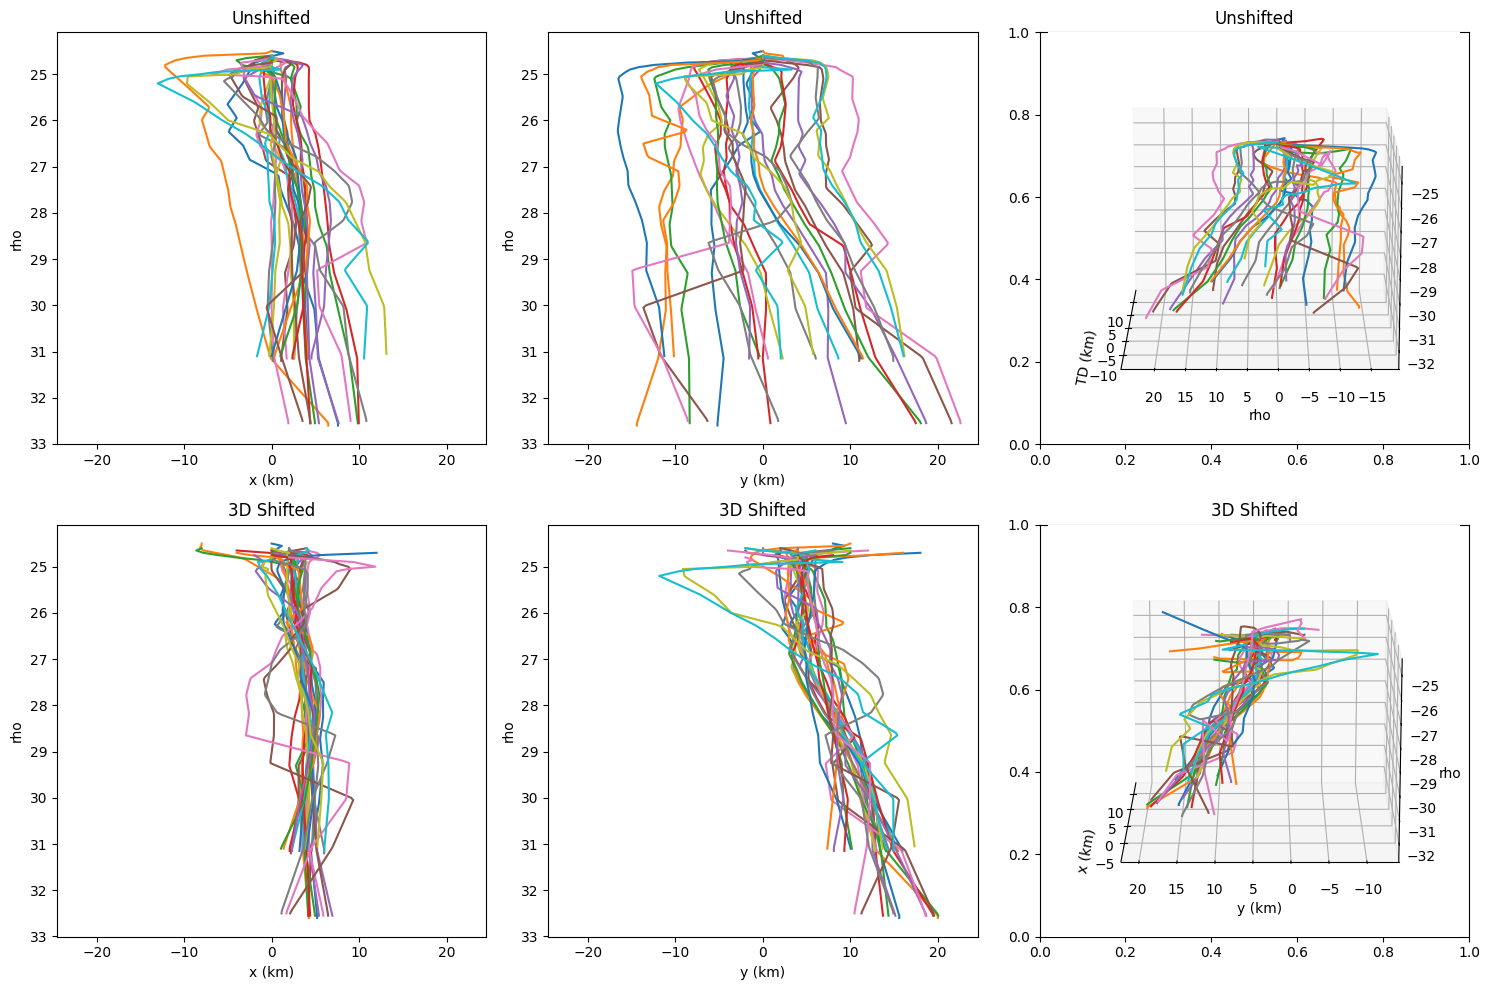

In [62]:
# SHFIT RESULTS
from mpl_toolkits.mplot3d import Axes3D
fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 

ax1 = axs[0,2].inset_axes([0, 0, 1, 1], projection='3d') 
ax2 = axs[1,2].inset_axes([0, 0, 1, 1], projection='3d')
for t in range(30):

    theta = best_shift_3D_df.loc[t]['theta']
    i = best_shift_3D_df.loc[t]['i']
    j = best_shift_3D_df.loc[t]['j']

    x = rho_df['x'+str(t)]/1000
    y = rho_df['y'+str(t)]/1000

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j
    
    
    axs[0,0].plot(x, rho_df.index)
    axs[0,0].set_xlabel('x (km)')
    axs[0,0].set_ylabel('rho')
    axs[0,0].set_title('Unshifted')

    axs[1,0].plot(x_shifted, rho_df.index)
    axs[1,0].set_xlabel('x (km)')
    axs[1,0].set_ylabel('rho')
    axs[1,0].set_title('3D Shifted')


    axs[0,1].plot(y, rho_df.index)
    axs[0,1].set_xlabel('y (km)')
    axs[0,1].set_ylabel('rho')
    axs[0,1].set_title('Unshifted')

    axs[1,1].plot(y_shifted, rho_df.index)
    axs[1,1].set_xlabel('y (km)')
    axs[1,1].set_ylabel('rho')
    axs[1,1].set_title('3D Shifted')
    
    # 3d plots
    ax1.plot(x, y, -rho_df.index)
    ax1.set_xlabel('TD (km)')
    ax1.set_ylabel('rho')
    ax1.set_title('Unshifted')

    ax2.plot(x_shifted, y_shifted, -rho_df.index)
    ax2.set_xlabel('x (km)')
    ax2.set_ylabel('y (km)')
    ax2.set_zlabel('rho')
    ax2.set_title('3D Shifted')

xmax = 0
xmin = 0
for l, ax in enumerate(axs.flat):
    if l in [0, 1, 3, 4]:
        xmax = max(ax.get_xlim()[1], xmax)
        xmin = min(ax.get_xlim()[0], xmin)
        ax.invert_yaxis()
  
axs[0,0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[0,1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1,0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1,1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))

ax1.view_init(15, 180)
ax2.view_init(15, 180)

plt.tight_layout()
plt.show()

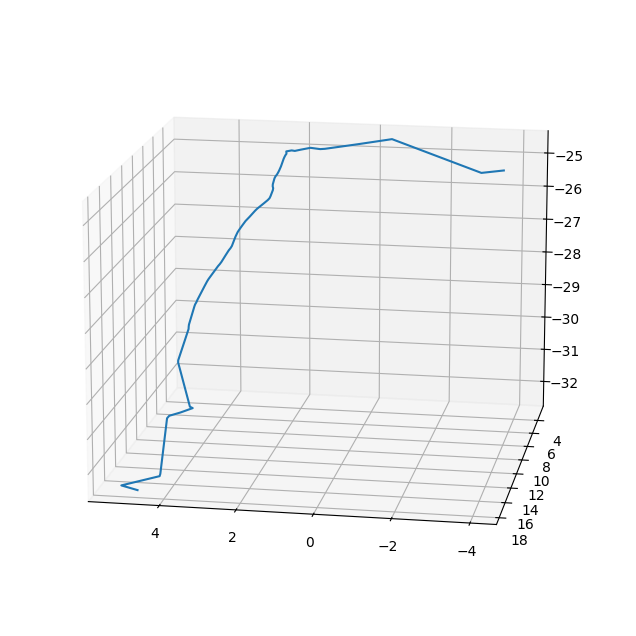

In [63]:
optimal_rho_df = rho_df.copy()
optimal_rho_df = optimal_rho_df.loc[:, ~optimal_rho_df.columns.str.contains('TD')]
for t in range(30):

    theta = best_shift_3D_df.loc[t]['theta']
    i = best_shift_3D_df.loc[t]['i']
    j = best_shift_3D_df.loc[t]['j']

    x = optimal_rho_df['x'+str(t)]/1000
    y = optimal_rho_df['y'+str(t)]/1000

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    optimal_rho_df['x'+str(t)] = x_shifted
    optimal_rho_df['y'+str(t)] = y_shifted

x_3D_mean = optimal_rho_df.filter(like='x').mean(axis=1)
x_3D_std = optimal_rho_df.filter(like='x').std(axis=1)
y_3D_mean = optimal_rho_df.filter(like='y').mean(axis=1)
y_3D_std = optimal_rho_df.filter(like='y').std(axis=1)

TD_3D_mean = np.hypot(x_3D_mean - x_3D_mean.iloc[0], y_3D_mean - y_3D_mean.iloc[0])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_3D_mean, y_3D_mean, -x_3D_mean.index)
ax.view_init(15, 100)


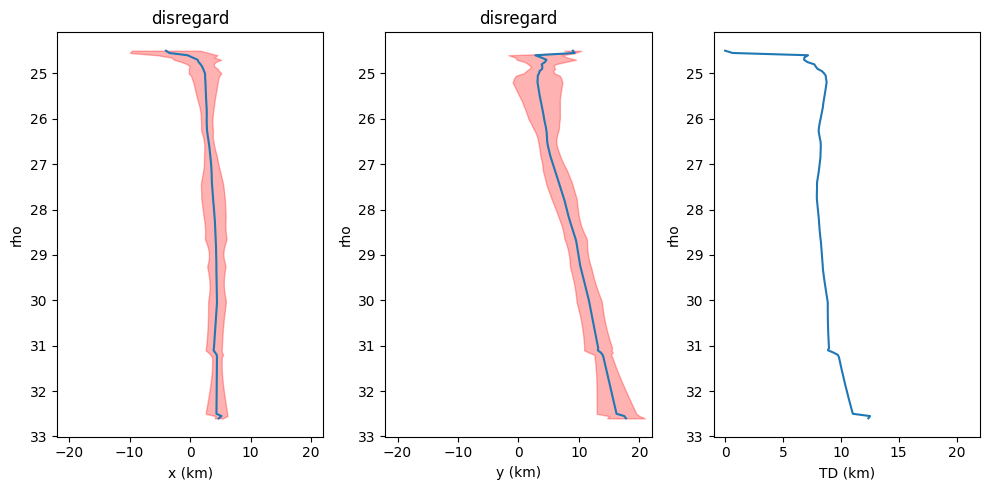

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5)) 

axs[0].plot(x_3D_mean, x_3D_mean.index)
axs[0].fill_betweenx(x_3D_std.index, x_3D_mean - x_3D_std, x_3D_mean + x_3D_std, color='r', alpha=.3)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('rho')
axs[0].set_title('disregard')

axs[1].plot(y_3D_mean, y_3D_mean.index)
axs[1].fill_betweenx(y_3D_std.index, y_3D_mean - y_3D_std, y_3D_mean + y_3D_std, color='r', alpha=.3)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('rho')
axs[1].set_title('disregard')

axs[2].plot(TD_3D_mean, TD_3D_mean.index)
axs[2].set_xlabel('TD (km)')
axs[2].set_ylabel('rho')

xmax = 0
xmin = 0
for l, ax in enumerate(axs.flat):
    
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)
    ax.invert_yaxis()
  
axs[0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[2].set_xlim(-1, max(abs(xmin),abs(xmax)))

plt.tight_layout()